# 1. Data loading and model training.

In [16]:
# Import the necessary libraries, set the random seed, and configure some hyperparameters.
# “'AM', 'EM', 'QY', and 'LGAC' represent the absorption wavelength, emission wavelength, quantum yield, and molar absorptivity, respectively.”

import pandas as pd
import numpy as np
import os
import random
import copy
import dgl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import EarlyStopping, Meter
from dgllife.utils import AttentiveFPAtomFeaturizer, AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset
from dgllife.model.gnn import AttentiveFPGNN
from dgllife.model.readout import AttentiveFPReadout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
    print('use GPU')
    device = 'cuda'
else:
    print('use CPU')
    device = 'cpu'

seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
n_feats = atom_featurizer.feat_size('hv')
e_feats = bond_featurizer.feat_size('he')
print("n_feats", n_feats, "e_feats", e_feats)

graph_feat_size = 256
n_tasks = 4
dropout_g = 0.4
dropout_f = 0.5
dropout_l = 0.4

use GPU
n_feats 39 e_feats 10


In [17]:
# Generate training and testing datasets.
def load_data_with_fp(data, fp_data, name, load):
    dataset = MoleculeCSVDataset(data,
                                 smiles_to_graph=smiles_to_bigraph,
                                 node_featurizer=atom_featurizer,
                                 edge_featurizer=bond_featurizer,
                                 smiles_column='SMILES',
                                 cache_file_path=str(name)+'_dataset_cyanine_dir-training.bin',
                                 task_names=['AM','EM','QY','LGAC'],
                                 load=load, init_mask=True, n_jobs=1
                                )

    combined_data = []
    for i, data_tuple in enumerate(dataset):
        if len(data_tuple) == 3:
            smiles, graph, label = data_tuple
            mask = None
        else:
            smiles, graph, label, mask = data_tuple
        fp = torch.tensor(fp_data[i], dtype=torch.float32)
        combined_data.append((graph, fp, label, mask))
    return combined_data

In [18]:
# Fingerprint data loading.
def load_fingerprints(fp_file):
    df = pd.read_csv(fp_file, header=None)
    return torch.tensor(df.values, dtype=torch.float32)
    
train_data = pd.read_csv('./dataset_cyanine/random_train_1.csv')
test_data = pd.read_csv('./dataset_cyanine/random_test_1.csv')

scaler = StandardScaler()
train_data[['AM', 'EM', 'QY', 'LGAC']] = scaler.fit_transform(train_data[['AM', 'EM', 'QY', 'LGAC']])
test_data[['AM', 'EM', 'QY', 'LGAC']] = scaler.transform(test_data[['AM', 'EM', 'QY', 'LGAC']])

train_fp = load_fingerprints('./dataset_cyanine/random_train_1_morgan.csv')
test_fp = load_fingerprints('./dataset_cyanine/random_test_1_morgan.csv')

train_datasets = load_data_with_fp(train_data, train_fp, 'train', True)
test_datasets = load_data_with_fp(test_data, test_fp, 'test', True)

Loading previously saved dgl graphs...


E:\Anaconda\envs\dye37\lib\site-packages\ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loading previously saved dgl graphs...


In [19]:
# Define a multi-task model MTATFP
class GraphFingerprintsModel(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, fp_size, 
                 graph_feat_size=256, num_layers=2, num_timesteps=2, 
                 n_tasks=4, dropout_g=0, dropout_f=0, dropout_l=0):
        super(GraphFingerprintsModel, self).__init__()
        
        # Characterization of dye molecules.
        self.gnn = AttentiveFPGNN(node_feat_size=node_feat_size,
                                  edge_feat_size=edge_feat_size,
                                  num_layers=num_layers,
                                  graph_feat_size=graph_feat_size,
                                  dropout=dropout_g)
        self.readout = AttentiveFPReadout(feat_size=graph_feat_size,
                                          num_timesteps=num_timesteps,
                                          dropout=dropout_g)

        # Characterization of solvent molecules.
        self.fp_fc = nn.Sequential(
            nn.Linear(fp_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_f),
            nn.Linear(256, graph_feat_size)
        )
        
        # Combine dye features and solvent features.
        self.predict = nn.Sequential(
            nn.Dropout(dropout_l),
            nn.Linear(graph_feat_size * 2, 128),
            nn.ReLU(),
            nn.Linear(128, n_tasks)
        )
        
    def forward(self, g, node_feats, edge_feats, fingerprints, get_node_weight=False):
        if edge_feats is None or 'he' not in g.edata.keys():
            num_edges = g.number_of_edges()
            edge_feats = torch.zeros((num_edges, edge_feats.size(1))).to(g.device)
        
        node_feats = self.gnn(g, node_feats, edge_feats)
        
        if get_node_weight:
            graph_feats, node_weights = self.readout(g, node_feats, get_node_weight)
            fp_feats = self.fp_fc(fingerprints)
            combined_feats = torch.cat([graph_feats, fp_feats], dim=1)
            return self.predict(combined_feats), node_weights
        else:
            graph_feats = self.readout(g, node_feats, get_node_weight)
            fp_feats = self.fp_fc(fingerprints)
            combined_feats = torch.cat([graph_feats, fp_feats], dim=1)
            return self.predict(combined_feats)


In [20]:
# Custom dataset class.
class MolecularDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Collate function for data loading.
def collate_fn(batch):
    graphs, fps, labels, masks = zip(*batch)
    graphs = dgl.batch(graphs)
    fps = torch.stack(fps)
    labels = torch.stack(labels)
    masks = torch.stack(masks) if masks[0] is not None else None
    return graphs, fps, labels, masks

In [21]:
# Training function.
def train_model(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for graphs, fps, labels, masks in dataloader:

        graphs = graphs.to(device)
        fps = fps.to(device)
        labels = labels.to(device)
        masks = masks.to(device) if masks is not None else None

        node_feats = graphs.ndata['hv']
        edge_feats = graphs.edata['he']

        predictions = model(graphs, node_feats, edge_feats, fps)

        if masks is not None:
            loss = (criterion(predictions, labels) * masks).mean()
        else:
            loss = criterion(predictions, labels)
        
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

In [22]:
# Main function.
def main():
    node_feat_size = n_feats
    edge_feat_size = e_feats
    graph_feat_size = 256
    num_layers = 2
    num_timesteps = 2
    fp_size = train_fp.shape[1]
    n_tasks = 4
    dropout_g = 0.4
    dropout_f = 0.5
    dropout_l = 0.4
    batch_size = 32
    learning_rate = 1e-3
    epochs = 200
    patience = 20

    # Initialize the model.
    model = GraphFingerprintsModel(node_feat_size=node_feat_size,
                                   edge_feat_size=edge_feat_size,
                                   graph_feat_size=graph_feat_size,
                                   num_layers=num_layers,
                                   num_timesteps=num_timesteps,
                                   fp_size=fp_size,
                                   n_tasks=n_tasks,
                                   dropout_g=dropout_g,
                                   dropout_f=dropout_f,
                                   dropout_l=dropout_l).to(device)

    # Data loading.
    train_dataset = MolecularDataset(train_datasets)
    test_dataset = MolecularDataset(test_datasets)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

    # Loss function and optimizer.
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_since_improvement = 0

    for epoch in range(1, epochs + 1):
        train_loss = train_model(model, train_loader, optimizer, criterion)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for graphs, fps, labels, masks in test_loader:
                graphs = graphs.to(device)
                fps = fps.to(device)
                labels = labels.to(device)
                if masks is not None:
                    masks = masks.to(device)

                node_feats = graphs.ndata['hv']
                edge_feats = graphs.edata['he']

                predictions = model(graphs, node_feats, edge_feats, fps)
                if masks is not None:
                    loss = (criterion(predictions, labels) * masks).mean()
                else:
                    loss = criterion(predictions, labels)

                val_loss += loss.item()

            val_loss /= len(test_loader)
            print(f'Epoch {epoch}, test Loss: {val_loss:.4f}')

            # Early stopping strategy.
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_since_improvement = 0
                best_model_wts = copy.deepcopy(model.state_dict())
            else:
                epochs_since_improvement += 1
                if epochs_since_improvement >= patience:
                    print("Early stopping triggered.")
                    break

    # Save the best model.
    torch.save(best_model_wts, 'model_cyanine_dir-training.pth')
    print('Model parameters saved')

if __name__ == '__main__':
    main()

Epoch 1, Train Loss: 0.4423
Epoch 1, test Loss: 0.4662
Epoch 2, Train Loss: 0.3765
Epoch 2, test Loss: 0.3961
Epoch 3, Train Loss: 0.3268
Epoch 3, test Loss: 0.3889
Epoch 4, Train Loss: 0.3109
Epoch 4, test Loss: 0.3266
Epoch 5, Train Loss: 0.2858
Epoch 5, test Loss: 0.3054
Epoch 6, Train Loss: 0.2583
Epoch 6, test Loss: 0.2911
Epoch 7, Train Loss: 0.2369
Epoch 7, test Loss: 0.2708
Epoch 8, Train Loss: 0.2270
Epoch 8, test Loss: 0.2781
Epoch 9, Train Loss: 0.2103
Epoch 9, test Loss: 0.2404
Epoch 10, Train Loss: 0.1967
Epoch 10, test Loss: 0.2239
Epoch 11, Train Loss: 0.1887
Epoch 11, test Loss: 0.2177
Epoch 12, Train Loss: 0.1757
Epoch 12, test Loss: 0.1966
Epoch 13, Train Loss: 0.1656
Epoch 13, test Loss: 0.1982
Epoch 14, Train Loss: 0.1623
Epoch 14, test Loss: 0.1936
Epoch 15, Train Loss: 0.1495
Epoch 15, test Loss: 0.1802
Epoch 16, Train Loss: 0.1426
Epoch 16, test Loss: 0.1784
Epoch 17, Train Loss: 0.1373
Epoch 17, test Loss: 0.1684
Epoch 18, Train Loss: 0.1268
Epoch 18, test Loss:

# 模型在训练集和验证集上的结果

In [23]:
device = 'cpu'
train_dataset = MolecularDataset(train_datasets)
test_dataset = MolecularDataset(test_datasets)
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

In [24]:
fp_size = train_fp.shape[1]
# Initialize the model.
model = GraphFingerprintsModel(node_feat_size=n_feats,
                               edge_feat_size=e_feats,
                               graph_feat_size=256,
                               num_layers=2,
                               num_timesteps=2,
                               fp_size=fp_size,
                               n_tasks=4,
                               dropout_g=0.4,
                               dropout_f=0.5,
                               dropout_l=0.4).to(device)

# Load saved model parameters.
model.load_state_dict(torch.load('model_cyanine_dir-training.pth', map_location=device))
model.eval()

GraphFingerprintsModel(
  (gnn): AttentiveFPGNN(
    (init_context): GetContext(
      (project_node): Sequential(
        (0): Linear(in_features=39, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge1): Sequential(
        (0): Linear(in_features=49, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge2): Sequential(
        (0): Dropout(p=0.4, inplace=False)
        (1): Linear(in_features=512, out_features=1, bias=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (attentive_gru): AttentiveGRU1(
        (edge_transform): Sequential(
          (0): Dropout(p=0.4, inplace=False)
          (1): Linear(in_features=256, out_features=256, bias=True)
        )
        (gru): GRUCell(256, 256)
      )
    )
    (gnn_layers): ModuleList(
      (0): GNNLayer(
        (project_edge): Sequential(
          (0): Dropout(p=0.4, inplace=False)
          (1): Linear(in_features=512, out_f

In [25]:
# Prediction.
def predict(model, dataloader):
    all_predictions = []
    with torch.no_grad():
        for graphs, fps, _, _ in dataloader:
            graphs = graphs.to(device)
            fps = fps.to(device)

            node_feats = graphs.ndata['hv']
            edge_feats = graphs.edata['he']

            predictions = model(graphs, node_feats, edge_feats, fps)
            all_predictions.append(predictions.cpu().numpy())

    return np.vstack(all_predictions)

train_predictions = predict(model, train_loader)
test_predictions = predict(model, test_loader)

# Save prediction results to a CSV file.
def save_predictions(predictions, file_name):
    df = pd.DataFrame(predictions, columns=['AM','EM','QY','LGAC'])
    df.to_csv(file_name, index=False)

# After prediction, reverse the normalization of the predicted results.
def reverse_standardization(predictions, scaler):
    return scaler.inverse_transform(predictions)

train_scale_predictions = reverse_standardization(train_predictions, scaler)
test_scale_predictions = reverse_standardization(test_predictions, scaler)

save_predictions(train_scale_predictions, 'train_predictions_cyanine_dir-training.csv')
save_predictions(test_scale_predictions, 'test_predictions_cyanine_dir-training.csv')
print("Predictions saved to train_predictions.csv")
print("Predictions saved to test_predictions.csv")

Predictions saved to train_predictions.csv
Predictions saved to test_predictions.csv


In [26]:
# Evaluation function.
def compute_metrics(pred_file, true_file, tasks=['AM', 'EM', 'QY', 'LGAC']):

    predictions = pd.read_csv(pred_file)  # 预测值
    true_labels = pd.read_csv(true_file)  # 真实值
    
    # Replace missing labels with NaN.
    true_labels.replace([None, ''], np.nan, inplace=True)
    predictions.replace([None, ''], np.nan, inplace=True)
    metrics = {}

    for task in tasks:
        true_task = true_labels[task]
        pred_task = predictions[task]

        mask = ~true_task.isna()
        true_task = true_task[mask]
        pred_task = pred_task[mask]

        mae = mean_absolute_error(true_task, pred_task)
        rmse = np.sqrt(mean_squared_error(true_task, pred_task))
        r2 = r2_score(true_task, pred_task)

        metrics[task] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"Task: {task} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    all_true = true_labels[tasks].to_numpy().flatten()
    all_pred = predictions[tasks].to_numpy().flatten()

    mask = ~np.isnan(all_true)
    all_true = all_true[mask]
    all_pred = all_pred[mask]

    overall_mae = mean_absolute_error(all_true, all_pred)
    overall_rmse = np.sqrt(mean_squared_error(all_true, all_pred))
    overall_r2 = r2_score(all_true, all_pred)

    metrics['Overall'] = {'MAE': overall_mae, 'RMSE': overall_rmse, 'R2': overall_r2}

    print(f"Overall - MAE: {overall_mae:.4f}, RMSE: {overall_rmse:.4f}, R2: {overall_r2:.4f}")
    
    return metrics

In [27]:
# Calculate performance metrics for the training and test sets.
train_metrics = compute_metrics('train_predictions_cyanine_dir-training.csv', './dataset_cyanine/random_train_1.csv')
test_metrics = compute_metrics('test_predictions_cyanine_dir-training.csv', './dataset_cyanine/random_test_1.csv')

Task: AM - MAE: 7.6141, RMSE: 10.1376, R2: 0.9919
Task: EM - MAE: 7.6773, RMSE: 11.1681, R2: 0.9842
Task: QY - MAE: 0.0168, RMSE: 0.0257, R2: 0.9676
Task: LGAC - MAE: 0.0411, RMSE: 0.0580, R2: 0.9733
Overall - MAE: 4.6332, RMSE: 8.2303, R2: 0.9994
Task: AM - MAE: 13.0217, RMSE: 20.7589, R2: 0.9661
Task: EM - MAE: 15.3426, RMSE: 24.1029, R2: 0.9351
Task: QY - MAE: 0.0603, RMSE: 0.1003, R2: 0.5958
Task: LGAC - MAE: 0.1115, RMSE: 0.1851, R2: 0.6911
Overall - MAE: 8.3356, RMSE: 17.1404, R2: 0.9973


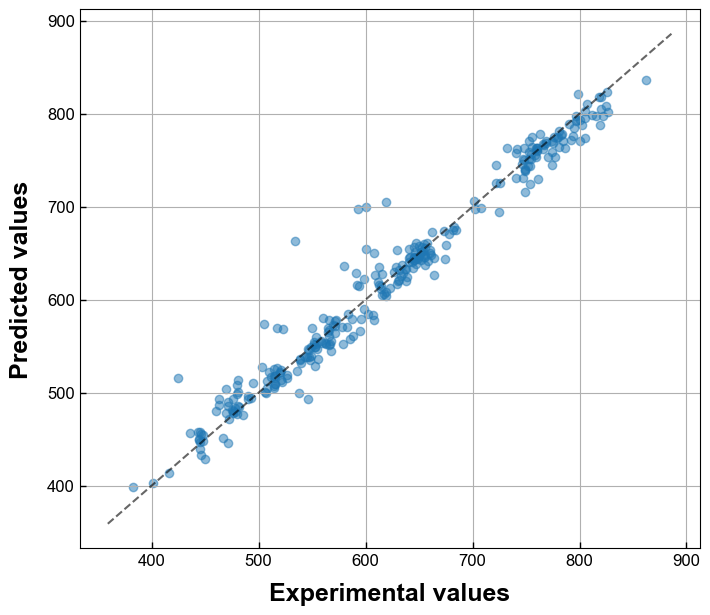

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

experiment_data = pd.read_csv('./dataset_cyanine/random_test_1.csv')
prediction_data = pd.read_csv('test_predictions_cyanine_dir-training.csv')

plt.figure(figsize=(8, 7))
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.scatter(experiment_data['AM'], prediction_data['AM'], alpha=0.5)
plt.xlabel('Experimental values', labelpad=10, fontweight='bold')
plt.ylabel('Predicted values', labelpad=10, fontweight='bold')
plt.tick_params(axis='x', direction='in', length=4, width=1)
plt.tick_params(axis='y', direction='in', length=4, width=1)

# 获取坐标轴范围
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [xmin, xmax], color='black', linestyle='--',alpha=0.6)

plt.grid(True)
plt.show()

# 3. Visualization of atomic weights.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import AttentiveFPAtomFeaturizer
from dgllife.utils import AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset
import dgl
import matplotlib
import matplotlib.cm as cm
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

def draw(mol_id, dataset, timestep):
    g, fps, label, _ = dataset[mol_id]
    g = dgl.batch([g])
    fps = fps.unsqueeze(0)
    atom_feats, bond_feats = g.ndata.pop('hv'), g.edata.pop('he')
    preds, atom_weights1 = model(g, atom_feats, bond_feats, fps, get_node_weight=True)
    assert timestep < len(atom_weights1)
    atom_weights1 = atom_weights1[timestep]
    min_value = torch.min(atom_weights1)
    max_value = torch.max(atom_weights1)
    atom_weights = (atom_weights1 - min_value) / (max_value - min_value)
    c=atom_weights.detach().cpu().numpy().flatten().tolist()
    norm = matplotlib.colors.Normalize(vmin=0,vmax=(sum(c)/len(c)))
    cmap = cm.get_cmap('summer_r') # viridis,magma,inferno,cividis,coolwarm,plasma,summer_r
    plt_colors = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) for i in range(g.number_of_nodes())}
    plt_colors._A = [] 
    cb = plt.colorbar(plt_colors) 
    cb.set_ticks([]) 
    
    smiless = train_data['SMILES']
    smiles=smiless[mol_id]
    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(300,300)
    
    drawer.SetFontSize(1)
    op = drawer.drawOptions().addAtomIndices=True
    
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol,highlightAtoms=range(g.number_of_nodes()),highlightBonds=[],
    highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    # 保存SVG图像
    svg_file_path = f"molecule_{mol_id}.svg"  # 设置文件名
    with open(svg_file_path, 'w') as f:
        f.write(svg)
    display(SVG(svg))
    avg_all_weight = sum(atom_weights)/len(atom_weights)
    list_a=[]
    num=0
    for i in atom_weights:
        list_a.append([i,num])
        num+=1
    return smiles,label,preds,list_a,avg_all_weight

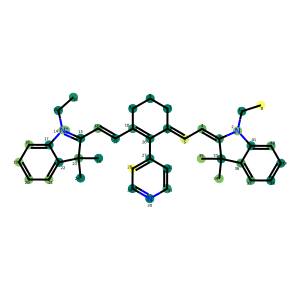

('CCN1/C(=C/C=C2\\CCCC(/C=C/C3=[N+](CC)c4ccccc4C3(C)C)=C2c2ccncc2)C(C)(C)c2ccccc21',
 tensor([1.1249, 0.9272, 0.5869, 1.0762]),
 tensor([[1.5802, 1.2392, 0.4474, 0.5129]], grad_fn=<AddmmBackward0>),
 [[tensor([0.0066], grad_fn=<UnbindBackward0>), 0],
  [tensor([0.7225], grad_fn=<UnbindBackward0>), 1],
  [tensor([0.1960], grad_fn=<UnbindBackward0>), 2],
  [tensor([0.3308], grad_fn=<UnbindBackward0>), 3],
  [tensor([0.2501], grad_fn=<UnbindBackward0>), 4],
  [tensor([0.0655], grad_fn=<UnbindBackward0>), 5],
  [tensor([0.3833], grad_fn=<UnbindBackward0>), 6],
  [tensor([0.7225], grad_fn=<UnbindBackward0>), 7],
  [tensor([0.5420], grad_fn=<UnbindBackward0>), 8],
  [tensor([0.5622], grad_fn=<UnbindBackward0>), 9],
  [tensor([0.3308], grad_fn=<UnbindBackward0>), 10],
  [tensor([0.3884], grad_fn=<UnbindBackward0>), 11],
  [tensor([0.2501], grad_fn=<UnbindBackward0>), 12],
  [tensor([0.8634], grad_fn=<UnbindBackward0>), 13],
  [tensor([0.1960], grad_fn=<UnbindBackward0>), 14],
  [tensor([1.], 

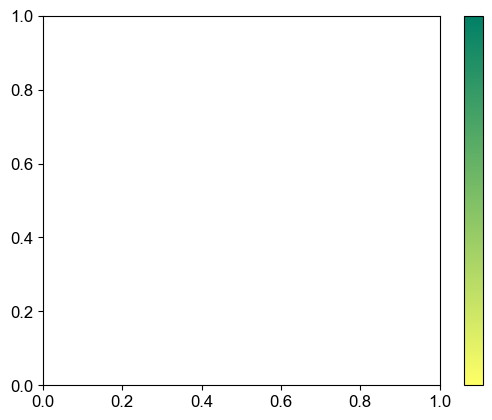

In [30]:
draw(0,train_datasets, 0)